# Extracting and analysing noise data from a Smart Citizen sensor
This notebook was written to download and analyse noise data from a smart citizen sensor. The sensor was installed in Nutgrove Avenue, Dublin, between May and August 2021. The code can be used to analyse any Smart Citizen Kit 2.1 device

The notebook is set up to compare one sensor to another - for example comparing a noisy street to a quiet reidential street. These comparisons are often the most robust way to use the sensor since it doesn't rely on the sensor / processing being particularly accurate relative to a more professional recording device

In [18]:
#jupyter settings
%config Completer.use_jedi = False

#import scdata module for accessing SmartCitizen devices
from scdata.io.device_api import ScApiDevice
from scdata._config import config
config._out_level = 'DEBUG'
config._framework='jupyterlab'

#import other modules needed for analysis and visualisation

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
plt.rcParams['svg.fonttype'] = 'none'

In [19]:

# Input: a dataframe with mask column for noisy periods (default 'thresh')
# Output: a dataframe containing the duration, start, end, and peak location for each noisy period
def getNoiseDurations(df,noise_label='thresh'):
    # find peaks of width>200s (to identify 'day')
    from scipy.signal import find_peaks, peak_widths
    peaks,peak_props = find_peaks(df[noise_label], width=200)
    
    # for each peak, find duration by getting the time difference between start and end time values
    durations = [df.iloc[rbase].name - df.iloc[lbase].name      for (lbase,rbase) in zip(peak_props['left_bases'],peak_props['right_bases']) ]
    
    out_df = pd.DataFrame(data = {'durations':durations, 'left_base':df.iloc[peak_props['left_bases']].index, 'right_base':df.iloc[peak_props['right_bases']].index,
                                 'peak_iloc':peaks})
    # return dataframe with start index, end index, duration
    return out_df
    
# Read device data, process Noise data and extract noise duration data
def getNoiseDataFromDevice(device_id, min_date = None, max_date = None, frequency = '1Min', clean_na = None):
    #Set device for reading
    device = ScApiDevice(device_id)
    device.get_device_sensors()

    # Load data
    data = device.get_device_data(min_date = min_date, max_date = max_date, frequency = frequency, clean_na = clean_na);
    data.index = data.index.tz_localize(None) # Remove Time Zone, whcih helps with combining devices later
    
    # calculate rolling Leq
    # Convert dBA values to raw power values. 
    #anti-log of scaled data
    data['NOISE_anti'] = 10**(data['NOISE_A']/10)
    
    # Caluculate the mean of the raw values
    #rolling average of exponentially weighted window
    data['noise_rolling'] = data['NOISE_anti'].ewm(span = 100).mean() #.rolling(center=True, window=100,min_periods=2).mean()
    
    # or the RMS of a standard window if you prefer (uncomment)
    #data['noise_rolling'] = data['NOISE_anti'].rolling(center=True, window='60min',min_periods=2).apply(lambda x: np.sqrt(np.mean(np.square(x))))
    
    # Convert back to dBA values
    data['noise_rolling'] = 10*np.log10(data['noise_rolling'])
    
    #calculate noisy periods using threshold
    data['thresh'] = data.noise_rolling>55
    data['thresh'] = data['thresh'].astype(int)
    
    #identify weekdays/weekend days
    data['TimeStamp'] = data.index
    data['time_of_day'] = data.TimeStamp - data.TimeStamp.dt.normalize()
    data['weekend'] = data.index.weekday>4
    
    #get durations
    durations = getNoiseDurations(data,'thresh')
    durations = durations.assign(weekend=data.iloc[durations.peak_iloc].weekend.values)
    
    return data,durations
    
    

In [4]:
# A dictionary defining the devices and periods that you want to analyse.
# For each device, you define a name, min_date, max_date, and device_id
# Find your device_id from the smart citizen website url. For example, for Nutgrove Avenue, device_id is 13982 and url is https://smartcitizen.me/kits/13982

devices = {'Nutgrove Avenue':{'min_date' : "2021-05-17", 'max_date' : "2021-08-22", 'device_id' : '13982'},
          'Quiet Residential Street':{'min_date' : "2021-05-17", 'max_date' : "2021-08-22",'device_id' : '12594'}}

# We read each device, and combine it into one large dataframe
all_devices_data = []
all_devices_durations = []

for dev_name,dev_props in devices.items():
   
    data,durations = getNoiseDataFromDevice(min_date=dev_props['min_date'], max_date=dev_props['max_date'], device_id = dev_props['device_id'])
    all_devices_data.append( data.assign(device = dev_name))
    all_devices_durations.append( durations.assign(device = dev_name))

all_devices_data = pd.concat(all_devices_data)
all_devices_durations = pd.concat(all_devices_durations)
    

[2021-11-11 13:50:13] - [WARNING] Admin Bearer not found
[2021-11-11 13:50:13] - [INFO] Requesting data from SC API
[2021-11-11 13:50:13] - [INFO] Device ID: 13982
[2021-11-11 13:50:13] - [INFO] Using rollup: 1m
[2021-11-11 13:50:13] - [INFO] Device 13982 is located at 53.2924516, -6.2711888
[2021-11-11 13:50:13] - [INFO] Device 13982 timezone is Europe/Dublin
[2021-11-11 13:50:13] - [INFO] Device 13982 has last reading at 2021-11-11T13:48:17Z
[2021-11-11 13:50:13] - [INFO] Device 13982 was added at 2021-04-13T14:52:03Z
[2021-11-11 13:50:13] - [INFO] Min Date: 2021-05-17T00:00:00
[2021-11-11 13:50:13] - [INFO] Max Date: 2021-08-22T00:00:00
[2021-11-11 13:50:13] - [INFO] Kit ID: 26
[2021-11-11 13:50:13] - [INFO] Device timezone: Europe/Dublin
[2021-11-11 13:50:13] - [INFO] Sensor IDs: [113, 112, 14, 10, 53, 58, 89, 88, 87, 56, 55]
[2021-11-11 13:51:02] - [SUCCESS] Device 13982 loaded successfully from API
[2021-11-11 13:51:03] - [WARNING] Admin Bearer not found
[2021-11-11 13:51:03] - [

In [5]:
# Check the first few lines of data to see if they seem reasonable
all_devices_data.head()

# Save the device data for future processing without needing to download again
all_devices_data.to_csv("all_devices_data.csv")

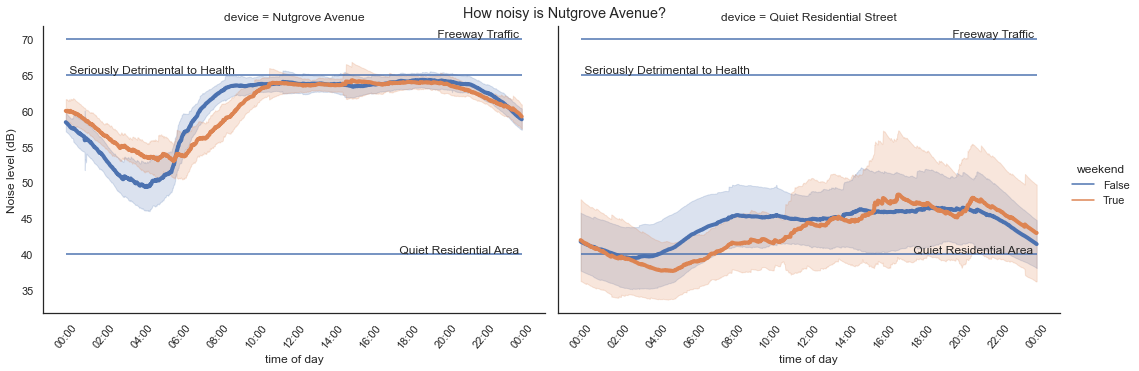

In [6]:
# Plot daily average

sns.set(context='notebook', style='white', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)

g = sns.relplot(
    data=all_devices_data,
    x="time_of_day", y="noise_rolling", col='device',hue = 'weekend',
    kind="line", linewidth=4,  aspect=1.5, legend='brief', estimator = np.mean, ci = 'sd'
)

g.fig.suptitle('How noisy is Nutgrove Avenue?')

# Beautify the plots a bit
for ax in g.axes.flatten():
    # set ticks each hour for 24 hours (in nanoseconds)
    xticks = np.linspace(0,60*60*24*10**9,13)   
    ax.set_xticks(xticks)
    
    ax.set_xlabel('time of day')
    ax.set_ylabel('Noise level (dB)')
    #ax.set_yscale('log')
    
    # convert all xtick labels to selected format from timestamp
    ax.set_xticklabels([pd.to_datetime(tm).strftime('%H:%M') for tm in xticks],
     rotation=50)

    ax.hlines(y=40, xmin=xticks[0], xmax=xticks[-1])
    ax.hlines(y=65, xmin=xticks[0], xmax=xticks[-1])
    ax.hlines(y=70, xmin=xticks[0], xmax=xticks[-1])
    ax.text(xticks[-1],40, ' Quiet Residential Area ', ha='right', va='bottom')
    ax.text(xticks[0],65, ' Seriously Detrimental to Health ', ha='left', va='bottom')
    ax.text(xticks[-1],70, ' Freeway Traffic ', ha='right', va='bottom')

In [11]:
#Save the figure to an svg or image file
g.fig.savefig("Noise.svg")  # You can save in other formats, just replace .svg with .pdf or .jpeg or .png

C:\Users\COLINB~1\AppData\Local\Temp/ipykernel_2104/1636777235.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ColinBoyle\Miniconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



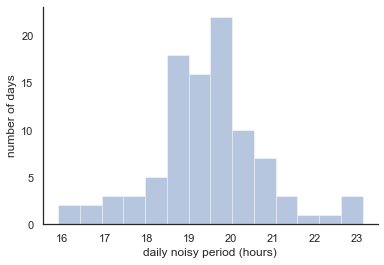

In [9]:
# filter out sensors other than Nutgrove
durations  = all_devices_durations[all_devices_durations.device == "Nutgrove Avenue"]

# Plot a histogram of the duration of noise per day
durations['time_s']=durations.durations.astype('timedelta64[s]')/3600 # convert seconds to hours

sns.distplot(durations['time_s'],kde=False)
sns.despine()
ax=plt.gca()
ax.set_xlabel('daily noisy period (hours)') 
ax.set_ylabel('number of days')
pd.to_datetime(durations['time_s'].mean()*3600e9).strftime('%H:%M')

# Save fig
plt.savefig("averageDuration.svg")

In [14]:
# Get the average daily noise duration (above 55dBA):
print('Mean Daily noise = ' + pd.to_datetime(durations['time_s'].mean()*3600e9).strftime('%H:%M') + " hours")

Mean Daily noise = 19:27 hours


C:\Users\COLINB~1\AppData\Local\Temp/ipykernel_2104/3291617736.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



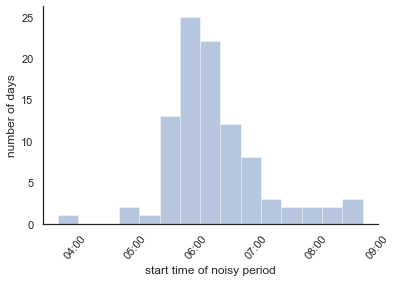

In [10]:
# Plot the start time of noise

d = durations.left_base

d = d - d.dt.normalize()

d = d.astype('timedelta64[s]')/3600
sns.distplot(d,kde=False)
sns.despine()
ax=plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([pd.to_datetime(tm*3600e9).strftime('%H:%M') for tm in xticks],
 rotation=50)
ax.set_xlabel('start time of noisy period') 
ax.set_ylabel('number of days')

# Save Fig
plt.savefig("averageStartTime.svg")

In [11]:
print('Noisy period start time = ' + pd.to_datetime(d.mean()*3600e9).strftime('%H:%M'))

Noisy period start time = 06:17


C:\Users\COLINB~1\AppData\Local\Temp/ipykernel_2104/3559287501.py:12: UserWarning:

FixedFormatter should only be used together with FixedLocator



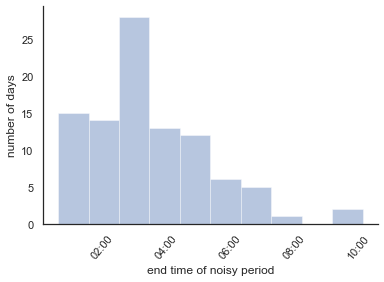

In [12]:
# Plot end time of noisy period
d = durations.right_base

d = d - d.dt.normalize()

d = d.astype('timedelta64[s]')/3600
d = d + (d<10)*(d+24)
sns.distplot(d,kde=False)
sns.despine()
ax=plt.gca()
xticks = ax.get_xticks()
ax.set_xticklabels([pd.to_datetime(tm*3600e9).strftime('%H:%M') for tm in xticks],
 rotation=50)
ax.set_xlabel('end time of noisy period') 
ax.set_ylabel('number of days')
pd.to_datetime(d.mean()*3600e9).strftime('%H:%M')

#save figure
plt.savefig("averageEndTime.svg")

In [13]:
print('Noisy period end time = ' + pd.to_datetime(d.mean()*3600e9).strftime('%H:%M'))

Noisy period end time = 03:30


In [15]:
# Calculate Lden for a day https://en.wikipedia.org/wiki/Day%E2%80%93evening%E2%80%93night_noise_level
def getLden(df,col='noise_rolling'):
    Lden =  10*np.log10((1/24)*(
        +12*10**((df.between_time('07:00','19:00')[col].mean())/10)
        +4*10**((df.between_time('19:00','23:00')[col].mean()+5)/10)
        +8*10**((df.between_time('23:00','07:00')[col].mean()+10)/10)
                       ))
    
    return Lden
                        
data = all_devices_data[all_devices_data.device == "Nutgrove Avenue"]              
dailyAverage = data.groupby(data.index.date).apply(lambda x: getLden(x))

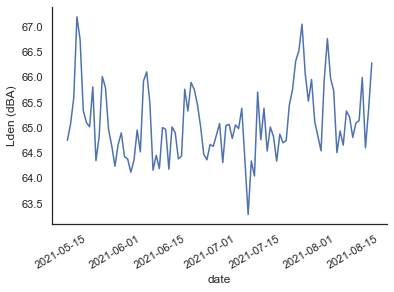

In [16]:
dailyAverage.plot(rot=30)
ax = plt.gca()
ax.set_ylabel('Lden (dBA)')
ax.set_xlabel('date')
sns.despine()

In [17]:
print("Average Day-Evening-Night Noise Level Lden (dBA) = " + str(dailyAverage.mean()))

Average Day-Evening-Night Noise Level Lden (dBA) = 65.1052579318673


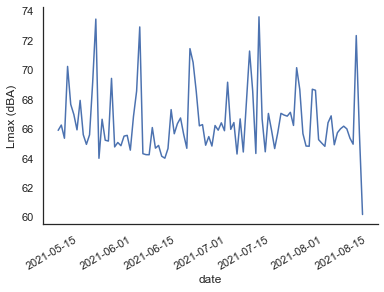

In [35]:
# Plot daily LMax
data.groupby(data.index.date).apply(lambda x: x.max()).noise_rolling.plot(rot=30)
ax = plt.gca()
ax.set_ylabel('Lmax (dBA)')
ax.set_xlabel('date')
sns.despine()

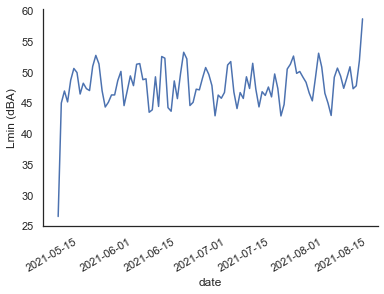

In [36]:
# Plot daily LMin
data.groupby(data.index.date).apply(lambda x: x.min()).noise_rolling.plot(rot=30)
ax = plt.gca()
ax.set_ylabel('Lmin (dBA)')
ax.set_xlabel('date')
sns.despine()